In [1]:
from getopt import getopt
import cloudpickle
import pickle
import sys
import os
import numpy as np
import pandas as pd
# import seaborn as sns
from scipy.special import logit, expit
from scipy.stats import uniform, norm, bernoulli, betabinom, spearmanr
from statsmodels.stats.proportion import proportions_ztest
from matplotlib import pyplot as plt
import pymc as pm
import arviz as az
from modeltools import mcmc_diagnostics, create_summary_stat
from downcast import downcast_df
import jax
from pymc.sampling_jax import sample_numpyro_nuts
from time import time, sleep
from datetime import timedelta

/home/roger/anaconda3/envs/bayes_topic_measures/lib/python3.10/site-packages/pymc/sampling_jax.py:37: UserWarning: This module is experimental.
  warnings.warn("This module is experimental.")


In [2]:
# GPU setting
SAMPLE_JAX = True
N_PROCESSES = 6

# Time
start_time = time()

# Reading in data
raw_data = pd.read_csv("data/unit_level_ratings.csv",index_col = 0)
raw_data = raw_data.sort_values(by=["corpus", "model", "topic"])

# Creating identifier for each corpus, model, and topic
# Identifier is unique for topic 
corpus_ids = (raw_data.groupby(["corpus"], as_index=False)
    .agg({"intrusion":"count"})
    .drop(columns="intrusion"))
corpus_ids["corpus_id"] = corpus_ids.index

model_ids = (raw_data.groupby(["model"], as_index=False)
    .agg({"intrusion":"count"})
    .drop(columns="intrusion"))
model_ids["model_id"] = model_ids.index

cordel_ids = (raw_data.groupby(["corpus", "model"], as_index=False)
    .agg({"intrusion":"count"})
    .drop(columns="intrusion"))
cordel_ids["cordel_id"] = cordel_ids.index 

topic_ids = (raw_data.groupby(["corpus", "model", "topic"], as_index=False)
    .agg({"intrusion":"count"})
    .drop(columns="intrusion"))
topic_ids["topic_id"] = topic_ids["topic"].astype(np.int16)

rater_ids = (raw_data.groupby(["corpus", "rater"], as_index=False)
    .agg({"intrusion":"count"})
    .drop(columns="intrusion"))
rater_ids["rater_id"] = rater_ids.index 

d1 = pd.merge(raw_data, corpus_ids, on=["corpus"], how="left")
d2 = pd.merge(d1, model_ids, on=["model"], how="left")
d3 = pd.merge(d2, cordel_ids, on=["corpus","model"], how="left")
d4 = pd.merge(d3, rater_ids, on=["corpus", "rater"], how="left")
data = pd.merge(d4, topic_ids, on=["corpus", "model", "topic"], how="left")
data = data[["corpus_id", "model_id", "cordel_id", "topic_id", "rater_id", "intrusion", "confidence"]]
data, na_s = downcast_df(data)

# Setting up numpy arrays for pymc
corpus_array = np.array(data["corpus_id"])
n_corpora = data["corpus_id"].nunique()

model_array = np.array(data["model_id"])
n_models = data["model_id"].nunique()

cordel_array = np.array(data["cordel_id"])
n_cordels = data["cordel_id"].nunique()

topic_array = np.array([data["cordel_id"], data["topic_id"]])
n_topics = data["topic_id"].nunique()

rater_array = np.array(data["rater_id"])
obs_n_raters = data["rater_id"].nunique()

score_array = np.array(data["intrusion"])

# Adding cordel id to topic_ids dataframe
topic_cordel_ids = pd.merge(topic_ids, cordel_ids, on=["corpus", "model"], how="left")

# Reading model
with open("bayesian_model/glmm.pickle", "rb") as f:
    inferred_glmm = cloudpickle.load(f)

In [7]:
raw_data["model"].value_counts()

etm       4169
dvae      4107
mallet    3922
Name: model, dtype: int64

In [13]:
# Join ss to itself and find point estmates for topic effects
ss = inferred_glmm["summary_stat"]
za = ss[ss["param"]=="za"]
za[["cordel_id", "topic_id"]] = za["param_num"].str.split(",", expand=True)
za["cordel_id"] = za["cordel_id"].str.strip().astype(int)
za["topic_id"] = za["topic_id"].str.strip().astype(int)

/tmp/ipykernel_18713/1723804245.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  za[["cordel_id", "topic_id"]] = za["param_num"].str.split(",", expand=True)
/tmp/ipykernel_18713/1723804245.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  za[["cordel_id", "topic_id"]] = za["param_num"].str.split(",", expand=True)
/tmp/ipykernel_18713/1723804245.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See t

In [43]:
# Aggregate raw data to find model precision
s = (data.groupby(["cordel_id", "topic_id"]).agg({"intrusion":"sum"})
     .reset_index().rename(columns={"intrusion":"sum"}))
c = (data.groupby(["cordel_id", "topic_id"]).agg({"intrusion":"count"})
     .reset_index().rename(columns={"intrusion":"count"}))
mp = pd.merge(s, c,on=["cordel_id", "topic_id"])
mp["model_precision"] = mp["sum"]/mp["count"]

In [44]:
# Join
mp = pd.merge(mp, za[["cordel_id", "topic_id", "mean"]], on=["cordel_id", "topic_id"])

In [45]:
for i in range(6):
    

,cordel_id,topic_id,sum,count,model_precision,mean
0,0,0,18,37,0.486486,-1.1357
1,0,1,24,31,0.774194,-0.1367
2,0,2,40,46,0.869565,0.2953
3,0,3,56,58,0.965517,1.1639
4,0,4,31,40,0.775000,-0.1818
...,...,...,...,...,...,...
295,5,45,19,36,0.527778,-0.8146
296,5,46,18,32,0.562500,-0.6670
297,5,47,25,44,0.568182,-0.7286
298,5,48,29,35,0.828571,0.2532


In [49]:
legend = {
    "firebrick":"nyt/dvae",
    "darkblue":"nyt/etm",
    "darkgreen":"nyt/lda",
    "orangered":"wiki/dvae",
    "royalblue":"wiki/etm",
    "mediumseagreen":"wiki/lda"
}
cordel = {key:i for i, key in enumerate(legend.keys())}

SpearmanrResult(correlation=0.997478696107559, pvalue=8.14116357841607e-57)
SpearmanrResult(correlation=0.997310426165605, pvalue=3.830693107215196e-56)
SpearmanrResult(correlation=0.995845090208537, pvalue=1.2862209131324858e-51)
SpearmanrResult(correlation=0.9958460419142353, pvalue=1.2791821842966785e-51)
SpearmanrResult(correlation=0.9970705515903698, pvalue=2.968813723624463e-55)
SpearmanrResult(correlation=0.9982711470912734, pvalue=9.586898594546744e-61)


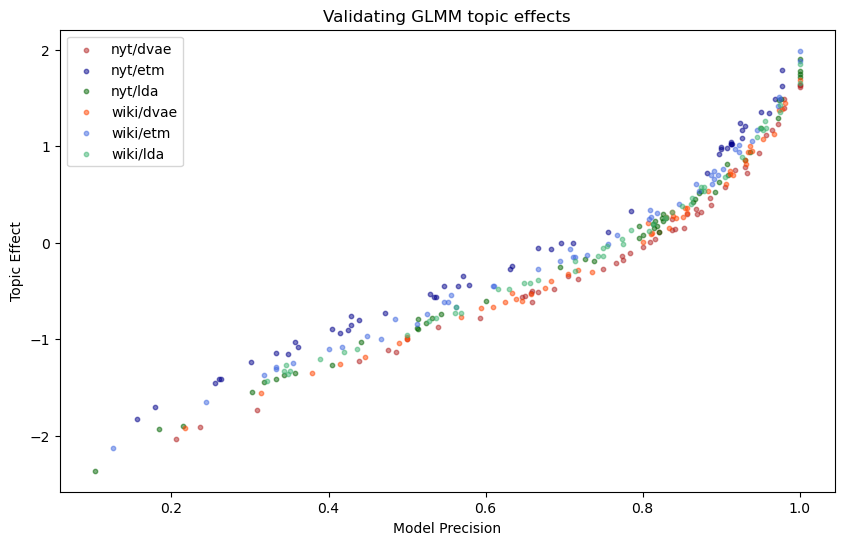

In [53]:
# Scatterplot topic effect vs model precision
fig, ax = plt.subplots(1, 1, figsize=(10,6))
for colour in legend.keys():
    x = mp[mp["cordel_id"]==cordel[colour]]["model_precision"]
    y = mp[mp["cordel_id"]==cordel[colour]]["mean"]
    print(spearmanr(x,y))
    ax.scatter(x, y, c=colour, label=legend[colour], s=10, alpha=0.5)
ax.set_title("Validating GLMM topic effects")
ax.set_xlabel("Model Precision")
ax.set_ylabel("Topic Effect")
ax.legend()
plt.show()